In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


Tamaño de X_augmented: (27030, 32, 32, 3), Tamaño de y_augmented: 27030


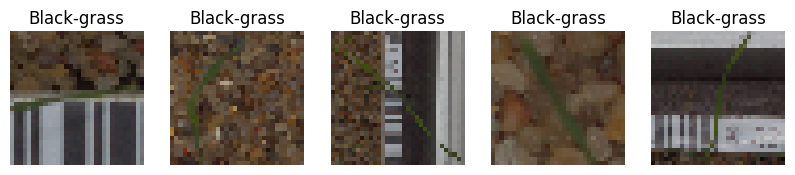

In [253]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import glob

# Definición de constantes
IMAGE_SIZE = (32, 32)  # Tamaño estándar para muchos modelos de CNN
NUM_CLASSES = 16  # Actualiza según tu conjunto de datos específico

# Función para cargar y preprocesar imágenes
def load_and_preprocess_images(image_paths, label_encoder=None):
    images = []
    labels = []
    
    for path in image_paths:
        # Extraer etiqueta del path
        label = path.split(os.path.sep)[-2]
        
        # Leer imagen
        img = cv2.imread(path)
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalizar valores de píxeles
        img = img / 255.0
        
        images.append(img)
        labels.append(label)
    
    # Codificar etiquetas
    if label_encoder is None:
        label_encoder = LabelEncoder()
        labels = label_encoder.fit_transform(labels)
    else:
        labels = label_encoder.transform(labels)
    
    return np.array(images), labels, label_encoder

# Función para rotar imágenes
def rotate_images(images, labels, angles):
    rotated_images = []
    rotated_labels = []

    for img, label in zip(images, labels):
        for angle in angles:
            # Rotar imagen
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
            rotated_images.append(rotated_img)
            rotated_labels.append(label)

    return np.array(rotated_images), np.array(rotated_labels)

# Cargar las rutas de las imágenes (modificar según la estructura de tu conjunto de datos)
train_image_paths = glob.glob('../datos/train/**/*.png', recursive=True)

# Preprocesar las imágenes de entrenamiento
X_train, y_train, label_encoder = load_and_preprocess_images(train_image_paths)

# Definir los ángulos para rotar las imágenes
rotation_angles = [0, 90, 180, 270]  # Ángulos en grados

# Rotar las imágenes y obtener nuevas imágenes y etiquetas
X_rotated, y_rotated = rotate_images(X_train, y_train, rotation_angles)

# Combinar las imágenes originales y rotadas
X_augmented = np.concatenate((X_train, X_rotated), axis=0)
y_augmented = np.concatenate((y_train, y_rotated), axis=0)

# Imprimir tamaños del nuevo conjunto de entrenamiento
print(f"Tamaño de X_augmented: {X_augmented.shape}, Tamaño de y_augmented: {len(y_augmented)}")

# Mostrar algunas imágenes aumentadas
num_images_to_show = 5  # Número de imágenes a mostrar
plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X_augmented[i])  # Mostrar la imagen procesada
    plt.title(label_encoder.inverse_transform([y_augmented[i]])[0])  # Muestra la etiqueta original
    plt.axis('off')
plt.show()


In [254]:
# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

# Si son iguales, realiza la división
X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

Longitud de X_train: 5406, Longitud de y_train: 5406
Longitud de X_train: 21624, Longitud de y_train: 21624


In [256]:
# Verifica que el número de muestras sea el mismo
print(f"Longitud de X_train: {len(X_train)}, Longitud de y_train: {len(y_train)}")

# Si son iguales, realiza la división
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Longitud de X_train: 17299, Longitud de y_train: 17299


In [257]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Reshape the data to be compatible with Logistic Regression (2D array)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

# Optionally scale the data to improve convergence and performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


log_reg = LogisticRegression(max_iter=400, solver="lbfgs", random_state=0, C=0.01)  # "multi_class='multinomial'" is optional now
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)

# Print the accuracy
print("Model Accuracy:", accuracy)

c:\Users\CRISTIAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Accuracy: 0.534393063583815


In [258]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 45   0   0   0   5   7  80   0   1   0   0   3   2   0   0   0]
 [  0 176   9   7   0   7   0   0  13   7  30  10   0   0   0   0]
 [  3   8 110   2   5   6  13   0  13   3   8   8   0   0   0   0]
 [  0   5   5 224   2  16   1  20  64  10   5  11   1   0   0   0]
 [  9   3  11   2  30  17  53   0   3   0   0   3   0   0   0   0]
 [ 16   3   3  23   8 140  76   3  10   2  18  22   0   0   0   0]
 [ 34   0  12   2  15  29 300   0   0   0   2  19   5   0   1   2]
 [  0   6   1  49   1   8   0  57  24  15   2   7   1   0   0   0]
 [  0   6   8  50   9  14  12   5 206   5   0   9   0   0   0   1]
 [  0   4   5  23   0   6   0   6  23  46  20   0   0   0   0   0]
 [  0  24   1  10   1   9   2   6   4   8 251   8   0   0   0   0]
 [  4   1   7  22   6  51  28   0  19   0   8  96   3   0   3   3]
 [  4   0   2   1   1   0   8   1   0   0   1   3  46  10  23   8]
 [  2   3   0   1   0   2   5   0   0   0   3   2  12  41  21  13]
 [  1   0   4   1   2   5   8   5   1   0   

In [259]:
import os
import glob
import numpy as np
import pandas as pd

def prepare_submission(model, model_type, label_encoder):
    # Cargar rutas de imágenes de prueba
    test_image_paths = glob.glob('../datos/test/*.png')
    test_images, _, _ = load_and_preprocess_images(test_image_paths, None)  # Se pasa None en lugar del codificador de etiquetas

    # Predicción
    if model_type == 'lr':
        # Asegúrate de que las imágenes se ajusten al formato necesario para la regresión logística (2D)
        test_images_flattened = test_images.reshape(test_images.shape[0], -1)  # Flatten las imágenes para regresión logística
        test_pred = model.predict(test_images_flattened)  # Predicción con regresión logística
        # Si la regresión logística usa probabilidades, convertimos a etiquetas de clase
        test_pred = np.argmax(test_pred, axis=1) if test_pred.ndim > 1 else test_pred  # Asegurarse de que las predicciones son etiquetas
    else:  # En caso de ser CNN
        test_pred = np.argmax(model.predict(test_images), axis=1)

    # Convertir predicciones al formato original de etiquetas
    test_pred_labels = label_encoder.inverse_transform(test_pred)

    # Crear el DataFrame de resultados
    submission_df = pd.DataFrame({
        'file': [os.path.basename(path) for path in test_image_paths],
        'species': test_pred_labels
    })

    # Asegurarse de que el directorio de resultados exista
    results_dir = '../resultados'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    # Guardar los resultados
    submission_df.to_csv(f'{results_dir}/{model_type}_submission.csv', index=False)
    print(f"Archivo de resultados guardado como: {model_type}_submission.csv")

# Llamada a la función para crear el archivo de resultados
prepare_submission(log_reg, 'lr', label_encoder)


Archivo de resultados guardado como: lr_submission.csv
